# IBM Data Science Professional Capstone Project
### Using Foursquare Data to Determine Best Neighborhood in Chicago to Open New Pizza Place
##### Data Processing, Exploration, and Feature Selection

In [1]:
import numpy as np
import pandas as pd
import geocoder
import requests
from pandas.io.json import json_normalize
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json
from IPython.display import HTML, display
from sklearn.feature_selection import SelectPercentile, f_regression
import string

### Initial Data Loads

In [2]:
#load geojson for folium maps
with open('chicago-community-areas.geojson') as json_data:
    geo_data = json.load(json_data)

#load tabular data
chicago_venues = pd.read_pickle('./all_venue_data.pkl')
chicago_neighborhoods = pd.read_pickle('./chicago_neighborhoods.pkl')

In [3]:
print(chicago_venues.shape)
chicago_venues.head()

(23933, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ALBANY PARK,41.96829,-87.72338,Marie's Pizza & Liquors,41.968132,-87.731533,Pizza Place
1,ALBANY PARK,41.96829,-87.72338,Golden Crust Pizzeria,41.965491,-87.708519,Pizza Place
2,ALBANY PARK,41.96829,-87.72338,The Local Pizzeria,41.975935,-87.713302,Pizza Place
3,ALBANY PARK,41.96829,-87.72338,Domino's Pizza,41.972413,-87.728497,Pizza Place
4,ALBANY PARK,41.96829,-87.72338,Pizza Hut,41.976879,-87.729477,Pizza Place


In [4]:
print(chicago_neighborhoods.shape)
chicago_neighborhoods.head()

(77, 233)


,GEOG,2000_POP,2010_POP,TOT_POP,UND19,A20_34,A35_49,A50_64,A65_74,A75_84,...,assoc_plus_pct,in_lbr_frc_pct,pct_pop_access_4_acres_per_1k,pct_pop_access_10_acres_per_1k,impervious_acres_per_hh,modhigh_ta_pop_pct,modhigh_ta_emp_pct,nonsov_pct,Latitude,Longitude
0,ALBANY PARK,57655,51542,51992,13299,14031,11658,8134,2603,1573,...,0.390574,0.807084,0.000000,0.0,0.050373,1.0,1.0,0.499174,41.96829,-87.72338
1,ARCHER HEIGHTS,12644,13393,13142,4017,2827,2925,1818,970,323,...,0.159882,0.805830,0.000000,0.0,0.270191,1.0,1.0,0.363994,41.81154,-87.72556
2,ARMOUR SQUARE,12032,13391,13455,2634,2816,2376,2522,1540,1097,...,0.265896,0.798455,0.200206,0.0,0.097348,1.0,1.0,0.620298,41.83458,-87.63189
3,ASHBURN,39584,41081,43792,12999,8377,9200,8567,3031,999,...,0.303683,0.787867,0.144637,0.0,0.153915,1.0,1.0,0.294516,41.74785,-87.70995
4,AUBURN GRESHAM,55928,48743,46278,11696,9176,7871,9857,3810,2966,...,0.223910,0.698409,0.027726,0.0,0.084098,1.0,1.0,0.401112,41.74319,-87.65504


### Some charting

Text(0,0.5,'Total Venues')

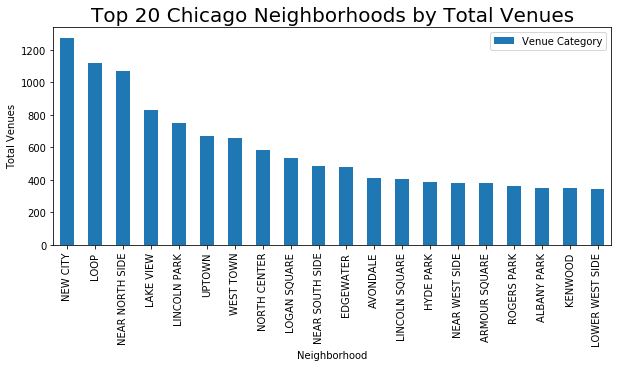

In [45]:
neighb_ranked = chicago_venues[['Neighborhood','Venue Category']]
neighb_ranked = neighb_ranked.groupby('Neighborhood').count().sort_values(by='Venue Category',ascending=False).head(20)

neighb_ranked.plot(kind='bar',figsize=(10,4))
plt.title('Top 20 Chicago Neighborhoods by Total Venues',size=20)
plt.ylabel('Total Venues')

Text(0,0.5,'Total Pizza Places')

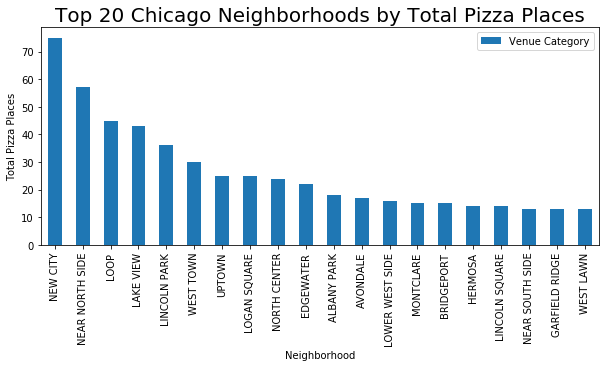

In [46]:
pizza_ranked = chicago_venues[['Neighborhood','Venue Category']]
pizza_ranked = pizza_ranked[pizza_ranked['Venue Category']=='Pizza Place']
pizza_ranked = pizza_ranked.groupby('Neighborhood').count().sort_values(by='Venue Category',ascending=False).head(20)

pizza_ranked.plot(kind='bar',figsize=(10,4))
plt.title('Top 20 Chicago Neighborhoods by Total Pizza Places',size=20)
plt.ylabel('Total Pizza Places')

### One Hot Encoding of Venues Data, Create Target Variable
We need a way to review the composition of each neighborhood's venues, and we can accomplish this with one hot encoding.

In [3]:
# one hot encoding
chicago_onehot = pd.get_dummies(chicago_venues[['Venue Category']], prefix="", prefix_sep="")
chicago_onehot = chicago_onehot.drop(columns=['Neighborhood']) #there is a neighborhood venue type that we can disregard

# add neighborhood column back to dataframe
chicago_onehot['Neighborhood'] = chicago_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [chicago_onehot.columns[-1]] + list(chicago_onehot.columns[:-1])
chicago_onehot = chicago_onehot[fixed_columns]

chicago_onehot.head()

,Neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,...,Warehouse Store,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,ALBANY PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ALBANY PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ALBANY PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ALBANY PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ALBANY PARK,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


There could be multiple venue types with the word pizza in it, so I want to make sure that I'm capturing everything.  I can look at all of the columns, but that may be error prone.  I can also set up a quick script to run through each column and check for the word pizza:

In [26]:
print([column for column in chicago_onehot.columns])

['Neighborhood', 'ATM', 'Accessories Store', 'Acupuncturist', 'Adult Boutique', 'Adult Education Center', 'Advertising Agency', 'Afghan Restaurant', 'African Restaurant', 'Airport', 'Airport Food Court', 'Airport Lounge', 'Airport Service', 'Airport Terminal', 'American Restaurant', 'Amphitheater', 'Animal Shelter', 'Antique Shop', 'Aquarium', 'Arcade', 'Arepa Restaurant', 'Argentinian Restaurant', 'Art Gallery', 'Art Museum', 'Arts & Crafts Store', 'Arts & Entertainment', 'Asian Restaurant', 'Assisted Living', 'Astrologer', 'Athletics & Sports', 'Auto Dealership', 'Auto Garage', 'Auto Workshop', 'Automotive Shop', 'BBQ Joint', 'Baby Store', 'Bagel Shop', 'Bakery', 'Bank', 'Bar', 'Baseball Field', 'Baseball Stadium', 'Basketball Court', 'Basketball Stadium', 'Beach', 'Bed & Breakfast', 'Beer Bar', 'Beer Garden', 'Beer Store', 'Big Box Store', 'Bike Rental / Bike Share', 'Bike Shop', 'Bike Trail', 'Bistro', 'Board Shop', 'Boat or Ferry', 'Bookstore', 'Botanical Garden', 'Boutique', 'Bow

In [27]:
cats = chicago_onehot.columns.tolist()

pizzas = []

for cat in cats:
    words = cat.rstrip()
    words = words.translate(words.maketrans('', '', string.punctuation))
    words = words.lower()
    words = words.split()
    
    for word in words:
        if word == 'pizza':
            pizzas.append(cat)

pizzas

['Pizza Place']

Looks like there is just 'Pizza Place', so I won't need to do anything further to capture all pizza places in one.

Having done this, I can now start taking a look at the data on a neighborhood level:

In [4]:
chicago_grouped = chicago_onehot.groupby('Neighborhood').mean().reset_index()
chicago_grouped.sort_values(by='Pizza Place',ascending=False).head(10)

,Neighborhood,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,...,Warehouse Store,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
27,GARFIELD RIDGE,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.005155,0.000000,0.000000,0.0
72,WEST LAWN,0.009615,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004808,0.0
44,MONTCLARE,0.004132,0.008264,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.004132,0.016529,0.000000,0.0
50,NEW CITY,0.000000,0.000785,0.0,0.000000,0.000000,0.000785,0.000000,0.0,0.000000,...,0.0,0.000785,0.000000,0.000000,0.000785,0.000000,0.000000,0.003140,0.007064,0.0
3,ASHBURN,0.006098,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.006098,0.000000,0.000000,0.000000,0.006098,0.006098,0.000000,0.0
47,NEAR NORTH SIDE,0.000000,0.000935,0.0,0.000000,0.003738,0.000935,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000935,0.000935,0.000000,0.005607,0.010280,0.0
16,CLEARING,0.000000,0.007407,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.007407,...,0.0,0.000000,0.000000,0.000000,0.007407,0.000000,0.000000,0.000000,0.007407,0.0
37,LAKE VIEW,0.000000,0.000000,0.0,0.002407,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.002407,0.000000,0.002407,0.000000,0.004813,0.020457,0.0
0,ALBANY PARK,0.000000,0.005731,0.0,0.000000,0.000000,0.000000,0.002865,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.005731,0.002865,0.005731,0.0
20,EAST SIDE,0.012346,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


Text(0,0.5,'Gym Frequency as Share of Total Neighborhood Venues')

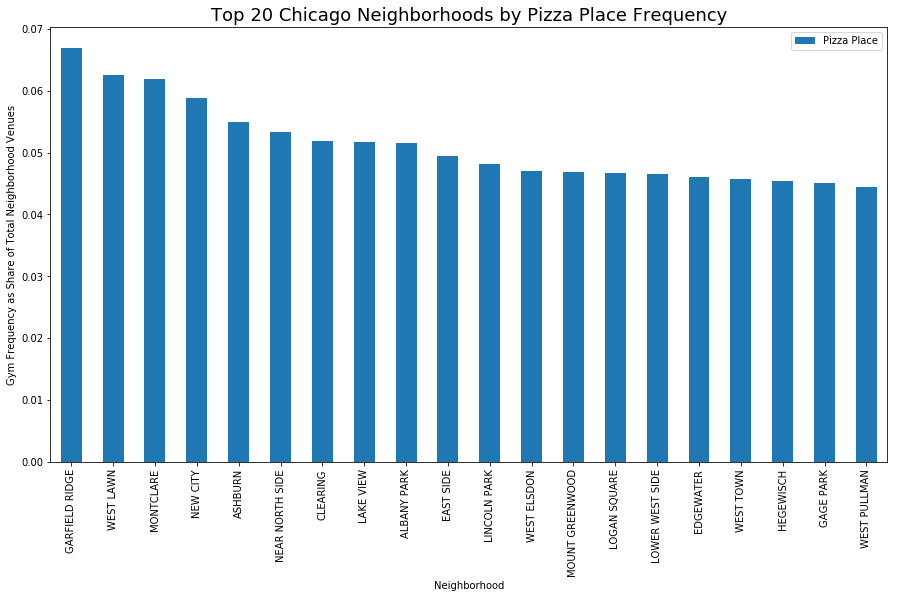

In [5]:
neighb_tar = chicago_grouped[['Neighborhood','Pizza Place']].set_index('Neighborhood')
neighb_tar.sort_values(by='Pizza Place',ascending=False).head(20).plot(kind='bar',figsize=(15,8))

plt.title('Top 20 Chicago Neighborhoods by Pizza Place Frequency',size=18)
plt.ylabel('Gym Frequency as Share of Total Neighborhood Venues')

#### Mapping this out:

In [30]:
foldf = neighb_tar.reset_index()

def embed_map(m):
    from IPython.display import IFrame

    m.save('index.html')
    return IFrame('index.html', width='100%', height='750px')

chimap = folium.Map(location=[41.84, -87.6298], zoom_start=10.5)

folium.Choropleth(
    geo_data=geo_data,
    name='choropleth',
    data=foldf,
    columns=['Neighborhood','Pizza Place'],
    key_on='feature.properties.community',
    fill_color='OrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Pizza Place Frequency'
).add_to(chimap)

# display map
embed_map(chimap)

### Add Community Venue Data to Neighborhood Demographic Dataset
##### Feature Selection

In [6]:
#merge datasets
m = chicago_neighborhoods.merge(chicago_grouped.reset_index(), left_on='GEOG', right_on='Neighborhood')
m.drop(columns='Neighborhood',inplace=True)
print(m.shape)

cols = m.columns.tolist()
ind = None

#find index of Pizza Place column and place near beginning of df
for index, col  in enumerate(cols):
    if col == 'Pizza Place':
        ind = index
        
cols = cols[0:1] + cols[ind:(ind+1)] + cols[1:ind] + cols[(ind+1):]
df = m[cols]
print(df.shape) #make sure shape matches original merged shape

(77, 717)
(77, 717)


In [7]:
df.head()

,GEOG,Pizza Place,2000_POP,2010_POP,TOT_POP,UND19,A20_34,A35_49,A50_64,A65_74,...,Warehouse Store,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo
0,ALBANY PARK,0.051576,57655,51542,51992,13299,14031,11658,8134,2603,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.005731,0.002865,0.005731,0.0
1,ARCHER HEIGHTS,0.032864,12644,13393,13142,4017,2827,2925,1818,970,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.004695,0.004695,0.000000,0.0
2,ARMOUR SQUARE,0.029024,12032,13391,13455,2634,2816,2376,2522,1540,...,0.0,0.0,0.005277,0.002639,0.0,0.0,0.013193,0.000000,0.005277,0.0
3,ASHBURN,0.054878,39584,41081,43792,12999,8377,9200,8567,3031,...,0.0,0.0,0.006098,0.000000,0.0,0.0,0.006098,0.006098,0.000000,0.0
4,AUBURN GRESHAM,0.009217,55928,48743,46278,11696,9176,7871,9857,3810,...,0.0,0.0,0.000000,0.000000,0.0,0.0,0.004608,0.000000,0.000000,0.0


I'm going to start by looking at a few variables that I think could be of note.  For example, total population appears to have a weak positive linear relationship with pizza place frequency:

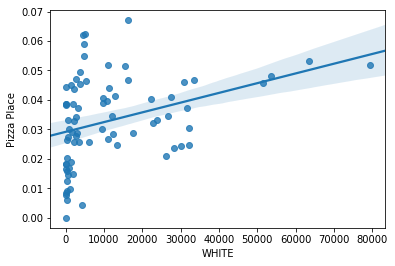

In [8]:
sns.regplot(x='WHITE',y='Pizza Place',data=df)

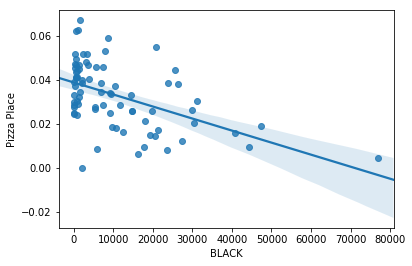

In [9]:
sns.regplot(x='BLACK',y='Pizza Place',data=df)

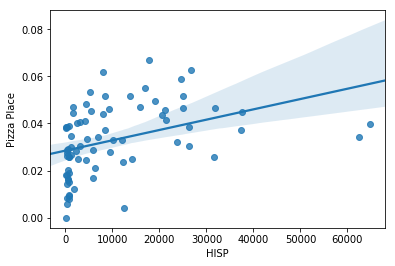

In [10]:
sns.regplot(x='HISP',y='Pizza Place',data=df)

And, it looks like frequency of bars in a neighborhood has a much more significant positive relationship with pizza place frequency:

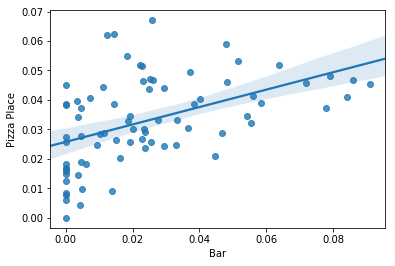

In [34]:
sns.regplot(x='Bar',y='Pizza Place',data=df)

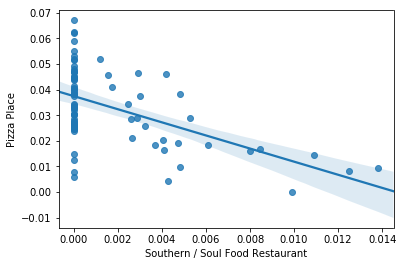

In [13]:
sns.regplot(x='Southern / Soul Food Restaurant',y='Pizza Place',data=df)

However, with 715 features, it would take forever to review each and every variable relationship 1 by 1.  Luckily there are tools available to do an initial pass of feature selection for us.  Knowing that there are 715 features, I can find the top 5% of features and then review those:

In [35]:
#initialize X and y
## using TotGym as dependent variable
y = df['Pizza Place']

## using numeric columns as X
cols = df.columns.tolist()
xcols = cols[2:]
x_int = df[xcols]
X = x_int.select_dtypes(exclude=['object'])

print(y.shape)
print(X.shape)

(77,)
(77, 695)


This gives us 35 variables to examine, which were chosen by f_regression score:

In [36]:
# Create and fit selector
selector = SelectPercentile(f_regression, percentile=5)
selector.fit(X, y)
# Get columns to keep and create new dataframe with those only
cols = selector.get_support(indices=True)
X_new = X.iloc[:,cols]
X_new.head()

C:\Users\mkriv\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:298: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\mkriv\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\mkriv\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\mkriv\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1821: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


,WHITE,HISP,BLACK,CARPOOL,INC_100_150K,MEDINC,OWN_OCC_HU,HV_150_300K,AVG_VMT,VACperc,...,Fried Chicken Joint,Gas Station,Gym,Gym / Fitness Center,High School,Hotel,Italian Restaurant,Mexican Restaurant,Park,Southern / Soul Food Restaurant
0,15608,24927,2401,2222,2326,58128.20513,6738,2652,11783.649450,0.004454,...,0.008596,0.000000,0.011461,0.005731,0.005731,0.000000,0.000000,0.017192,0.028653,0.000000
1,2213,10181,115,741,520,46632.12435,2110,1471,13482.202210,0.025773,...,0.004695,0.004695,0.009390,0.009390,0.004695,0.004695,0.004695,0.061033,0.028169,0.000000
2,1728,538,1218,934,549,26466.21622,1927,858,7679.484439,0.023159,...,0.005277,0.000000,0.007916,0.023747,0.034301,0.005277,0.007916,0.010554,0.052770,0.005277
3,4745,16924,20837,2296,2393,66560.12658,10946,6257,17837.275740,0.013212,...,0.024390,0.000000,0.012195,0.006098,0.018293,0.000000,0.006098,0.018293,0.067073,0.000000
4,324,862,44435,1136,1151,31694.19134,7389,2785,10588.320370,0.050596,...,0.013825,0.004608,0.000000,0.000000,0.036866,0.000000,0.000000,0.009217,0.050691,0.013825


In [37]:
X_new.columns

Index(['WHITE', 'HISP', 'BLACK', 'CARPOOL', 'INC_100_150K', 'MEDINC',
       'OWN_OCC_HU', 'HV_150_300K', 'AVG_VMT', 'VACperc', 'HCOV75K_LT20PCT',
       'FOR_BORN', 'NOT_ENGLISH', 'LING_ISO', 'SPANISH', '2000_WHITE',
       '2000_HISP', '2000_BLACK', 'in_lbr_frc_pct', 'ATM', 'Bakery', 'Bar',
       'Cosmetics Shop', 'Elementary School', 'Fast Food Restaurant',
       'Fried Chicken Joint', 'Gas Station', 'Gym', 'Gym / Fitness Center',
       'High School', 'Hotel', 'Italian Restaurant', 'Mexican Restaurant',
       'Park', 'Southern / Soul Food Restaurant'],
      dtype='object')

In [40]:
X_new.corr()

,WHITE,HISP,BLACK,CARPOOL,INC_100_150K,MEDINC,OWN_OCC_HU,HV_150_300K,AVG_VMT,VACperc,...,Fried Chicken Joint,Gas Station,Gym,Gym / Fitness Center,High School,Hotel,Italian Restaurant,Mexican Restaurant,Park,Southern / Soul Food Restaurant
WHITE,1.000000,0.089570,-0.287773,0.377639,0.949260,0.664018,0.841715,0.498737,-0.195313,-0.429840,...,-0.348543,-0.313409,0.643828,0.667976,-0.406231,0.283263,0.458712,-0.155046,-0.256327,-0.222146
HISP,0.089570,1.000000,-0.216820,0.859174,0.148831,-0.006465,0.290759,0.477323,0.198565,-0.274917,...,-0.232198,-0.009072,0.022089,0.011632,-0.148387,-0.012468,0.034664,0.609705,-0.277691,-0.313054
BLACK,-0.287773,-0.216820,1.000000,-0.049132,-0.115894,-0.414504,0.035212,0.017413,-0.275327,0.299822,...,0.460082,0.227426,-0.247279,-0.288194,0.263046,-0.147867,-0.342359,-0.234883,0.276230,0.362994
CARPOOL,0.377639,0.859174,-0.049132,1.000000,0.443110,0.130011,0.598484,0.629828,0.062348,-0.360845,...,-0.192694,-0.068857,0.194699,0.166447,-0.229659,0.008044,0.082924,0.353292,-0.292649,-0.266549
INC_100_150K,0.949260,0.148831,-0.115894,0.443110,1.000000,0.628819,0.909607,0.562079,-0.250103,-0.390382,...,-0.242348,-0.301290,0.642373,0.662132,-0.356365,0.325717,0.404651,-0.126487,-0.230293,-0.165835
MEDINC,0.664018,-0.006465,-0.414504,0.130011,0.628819,1.000000,0.578418,0.348192,0.246751,-0.534867,...,-0.269020,-0.350280,0.579950,0.540379,-0.508151,0.266683,0.494159,-0.094009,-0.380997,-0.351288
OWN_OCC_HU,0.841715,0.290759,0.035212,0.598484,0.909607,0.578418,1.000000,0.781140,-0.052734,-0.461275,...,-0.141308,-0.244435,0.484815,0.487532,-0.409722,0.256844,0.318436,-0.054421,-0.310394,-0.212536
HV_150_300K,0.498737,0.477323,0.017413,0.629828,0.562079,0.348192,0.781140,1.000000,0.213141,-0.502692,...,-0.059021,-0.160190,0.139317,0.173978,-0.331620,0.103420,0.144116,0.106925,-0.457009,-0.238125
AVG_VMT,-0.195313,0.198565,-0.275327,0.062348,-0.250103,0.246751,-0.052734,0.213141,1.000000,-0.313591,...,0.053952,-0.117208,-0.292653,-0.274882,-0.351987,-0.136668,0.056835,0.305010,-0.378861,-0.333275
VACperc,-0.429840,-0.274917,0.299822,-0.360845,-0.390382,-0.534867,-0.461275,-0.502692,-0.313591,1.000000,...,0.078733,0.340467,-0.289459,-0.253125,0.505044,-0.068775,-0.290825,-0.080711,0.560012,0.365998


Looks like I ended up with a nice mix of both demographic and venue variables, which is great.  We can check for correlations:

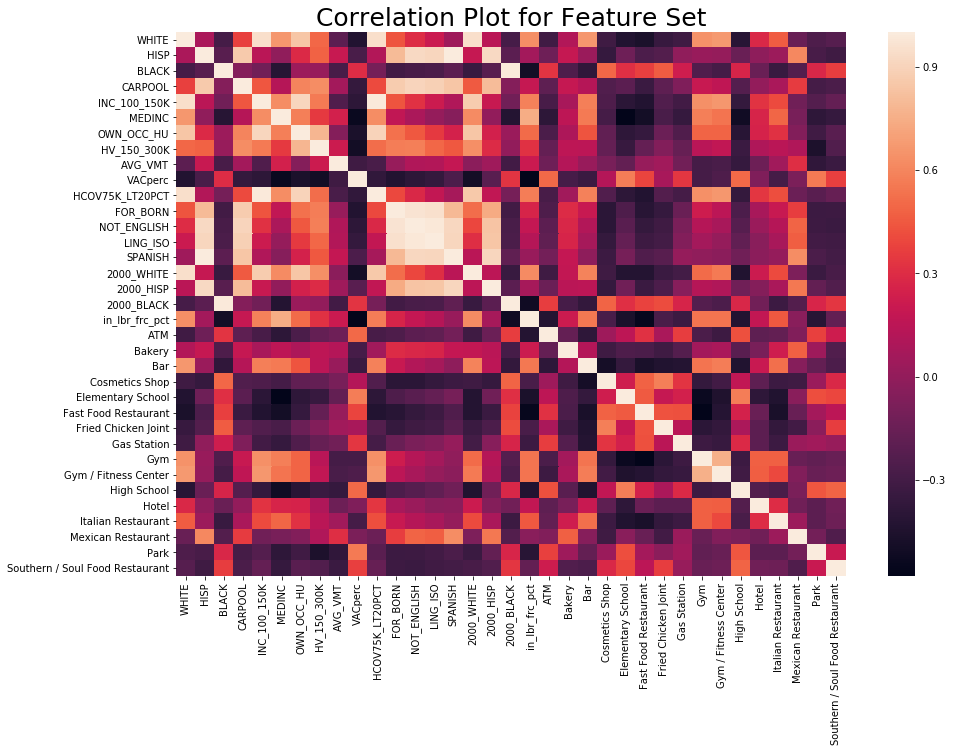

In [41]:
plt.figure(figsize=(15,10))
sns.heatmap(X_new.corr())
plt.title('Correlation Plot for Feature Set',size=25)
plt.show()

Let's drop a few columns that are highly correlated:

In [42]:
drop = ['FOR_BORN','NOT_ENGLISH','LING_ISO','SPANISH','2000_WHITE','2000_HISP','2000_BLACK','Gym / Fitness Center']
X_final = X_new.drop(columns=drop)
X_final.head()

,WHITE,HISP,BLACK,CARPOOL,INC_100_150K,MEDINC,OWN_OCC_HU,HV_150_300K,AVG_VMT,VACperc,...,Fast Food Restaurant,Fried Chicken Joint,Gas Station,Gym,High School,Hotel,Italian Restaurant,Mexican Restaurant,Park,Southern / Soul Food Restaurant
0,15608,24927,2401,2222,2326,58128.20513,6738,2652,11783.649450,0.004454,...,0.008596,0.008596,0.000000,0.011461,0.005731,0.000000,0.000000,0.017192,0.028653,0.000000
1,2213,10181,115,741,520,46632.12435,2110,1471,13482.202210,0.025773,...,0.023474,0.004695,0.004695,0.009390,0.004695,0.004695,0.004695,0.061033,0.028169,0.000000
2,1728,538,1218,934,549,26466.21622,1927,858,7679.484439,0.023159,...,0.013193,0.005277,0.000000,0.007916,0.034301,0.005277,0.007916,0.010554,0.052770,0.005277
3,4745,16924,20837,2296,2393,66560.12658,10946,6257,17837.275740,0.013212,...,0.024390,0.024390,0.000000,0.012195,0.018293,0.000000,0.006098,0.018293,0.067073,0.000000
4,324,862,44435,1136,1151,31694.19134,7389,2785,10588.320370,0.050596,...,0.036866,0.013825,0.004608,0.000000,0.036866,0.000000,0.000000,0.009217,0.050691,0.013825


In [43]:
X_final.columns

Index(['WHITE', 'HISP', 'BLACK', 'CARPOOL', 'INC_100_150K', 'MEDINC',
       'OWN_OCC_HU', 'HV_150_300K', 'AVG_VMT', 'VACperc', 'HCOV75K_LT20PCT',
       'in_lbr_frc_pct', 'ATM', 'Bakery', 'Bar', 'Cosmetics Shop',
       'Elementary School', 'Fast Food Restaurant', 'Fried Chicken Joint',
       'Gas Station', 'Gym', 'High School', 'Hotel', 'Italian Restaurant',
       'Mexican Restaurant', 'Park', 'Southern / Soul Food Restaurant'],
      dtype='object')

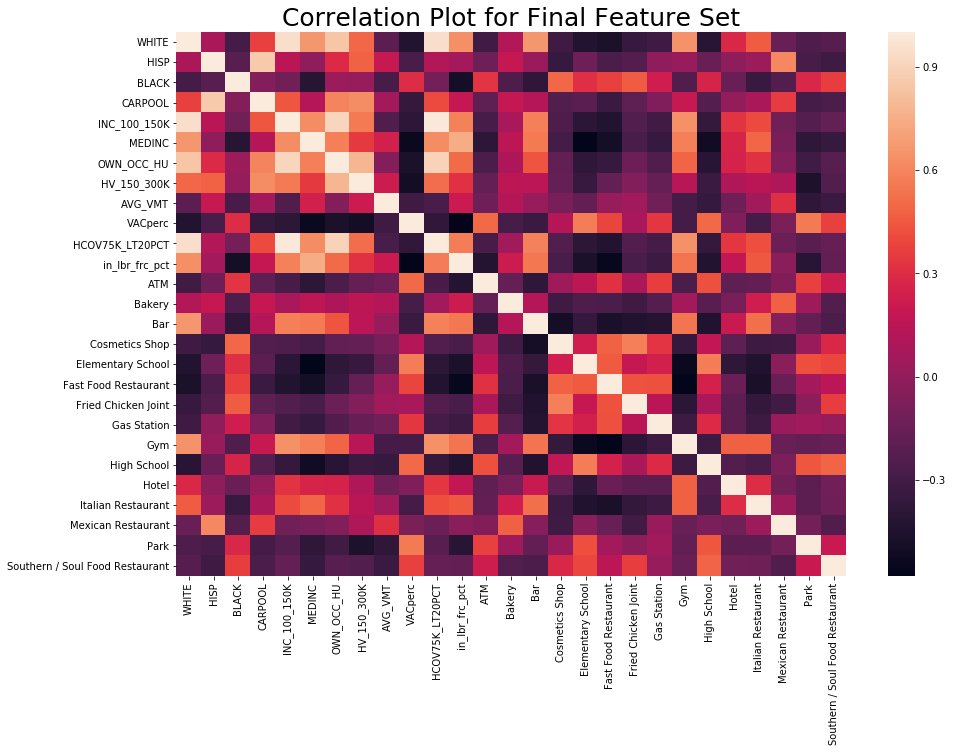

In [44]:
plt.figure(figsize=(15,10))
sns.heatmap(X_final.corr())
plt.title('Correlation Plot for Final Feature Set',size=25)
plt.show()

At this point, I'm happy with the final independent variable set.  I'll merge this with the neighborhood names, target variable, and latitude/longitudes for a final modeling set:

In [39]:
X_final['Neighborhood'] = df['GEOG']
X_final['Pizza Place'] = df['Pizza Place']
X_final['Latitude'] = df['Latitude']
X_final['Longitude'] = df['Longitude']

cols = X_final.columns.tolist()
cols = cols[-4:] + cols[:-4]
final_df = X_final[cols]
final_df.head()

,Neighborhood,Pizza Place,Latitude,Longitude,WHITE,HISP,BLACK,CARPOOL,INC_100_150K,MEDINC,...,Fried Chicken Joint,Gas Station,Gym,Gym / Fitness Center,High School,Hotel,Italian Restaurant,Mexican Restaurant,Park,Southern / Soul Food Restaurant
0,ALBANY PARK,0.051576,41.96829,-87.72338,15608,24927,2401,2222,2326,58128.20513,...,0.008596,0.000000,0.011461,0.005731,0.005731,0.000000,0.000000,0.017192,0.028653,0.000000
1,ARCHER HEIGHTS,0.032864,41.81154,-87.72556,2213,10181,115,741,520,46632.12435,...,0.004695,0.004695,0.009390,0.009390,0.004695,0.004695,0.004695,0.061033,0.028169,0.000000
2,ARMOUR SQUARE,0.029024,41.83458,-87.63189,1728,538,1218,934,549,26466.21622,...,0.005277,0.000000,0.007916,0.023747,0.034301,0.005277,0.007916,0.010554,0.052770,0.005277
3,ASHBURN,0.054878,41.74785,-87.70995,4745,16924,20837,2296,2393,66560.12658,...,0.024390,0.000000,0.012195,0.006098,0.018293,0.000000,0.006098,0.018293,0.067073,0.000000
4,AUBURN GRESHAM,0.009217,41.74319,-87.65504,324,862,44435,1136,1151,31694.19134,...,0.013825,0.004608,0.000000,0.000000,0.036866,0.000000,0.000000,0.009217,0.050691,0.013825


In [40]:
final_df.to_pickle('./df_for_model.pkl')